In [1]:
import sys
sys.path.append('../')
from utils import *
from model import *
from collections import defaultdict

In [2]:
data_dir = '/datadrive/data_cs/'
batch_size = 128
batch_num  = 128
epoch_num  = 200

device = torch.device("cuda:1")
graph = dill.load(open(data_dir + 'graph.pk', 'rb'))

In [3]:
train_range = {t: True for t in graph.times if t != None and t < 2015}
valid_range = {t: True for t in graph.times if t != None and t >= 2015  and t <= 2016}
test_range  = {t: True for t in graph.times if t != None and t > 2016}

In [4]:
# len(graph.node_feature['paper']['time'])
# tot = 0
# for t in train_range:
#     tot += np.sum(graph.node_feature['paper']['time'] == t)
# print(tot)
# tot = 0
# for t in valid_range:
#     tot += np.sum(graph.node_feature['paper']['time'] == t)
# print(tot)
# tot = 0
# for t in test_range:
#     tot += np.sum(graph.node_feature['paper']['time'] == t)
# print(tot)
# l = [377082, 77467, 89695]
# l = np.array(l)
# l / np.sum(l)

In [5]:
class GNN(nn.Module):
    def __init__(self, in_dim, n_hid, num_types, num_relations, n_heads, n_layers, dropout = 0.3):
        super(GNN, self).__init__()
        self.gcs = nn.ModuleList()
        self.num_types = num_types
        self.in_dim    = in_dim
        self.n_hid     = n_hid
        self.aggregat_ws   = nn.ModuleList()
        self.drop          = nn.Dropout(dropout)
        for t in range(num_types):
            self.aggregat_ws.append(nn.Linear(in_dim, n_hid))
        for l in range(n_layers):
            self.gcs.append(RAGCNConv(n_hid, n_hid, num_types, num_relations, n_heads, dropout))
    def set_device(self, device):
        self.device = device
        for gc in self.gcs:
            gc.device = device
    def forward(self, node_feature, node_type, edge_time, edge_index, edge_type):
        res = torch.zeros(node_feature.size(0), self.n_hid).to(node_feature.device)
        for t_id in range(self.num_types):
            aggregat_w = self.aggregat_ws[t_id]
            idx = (node_type == t_id)
            if idx.sum() == 0:
                continue
            res[idx] = torch.tanh(aggregat_w(node_feature[idx]))
        meta_xs = self.drop(res)
        del res
        for gc in self.gcs:
            meta_xs = gc(meta_xs, node_type, edge_index, edge_type, edge_time)
        return meta_xs
    
class CPC_Predictor(nn.Module):
    def __init__(self, in_dim, n_hid, num_types, num_relations, n_heads, n_layers, dropout = 0.3):
        super(CPC_Predictor, self).__init__()
        self.gnn = GNN(in_dim, n_hid, num_types, num_relations, n_heads, n_layers, dropout)
        self.matcher = nn.Linear(n_hid, n_heads)
        self.score   = nn.Linear(n_heads, 1)
        
    def forward(self, pos_paper_ids, neg_paper_ids, node_feature, node_type, edge_time, edge_index, edge_type):
        meta_xs = self.gnn(node_feature, node_type, edge_time, edge_index, edge_type)
        meta_xs = self.score(F.elu(self.matcher(meta_xs)))
        pos_res = meta_xs[pos_paper_ids]
        neg_res = meta_xs[neg_paper_ids]
        neg_res = neg_res.view(pos_res.size(0), neg_res.size(0) // pos_res.size(0))
        return torch.cat([pos_res, neg_res], dim=-1)

def gen_negative_sample(dim1, dim2, num):
    res = []
    for i in range(num):
        res += [[np.random.randint(dim1), np.random.randint(dim2)]]
    return res

def neg_sample(size, pos_id, num):
    res = {}
    while len(res) != num:
        s = np.random.choice(size)
        if s in res or s == pos_id:
            continue
        res[s] = True
    return list(res.keys())

In [6]:
def cpc_sample(seed, in_feature, in_times, in_edge_list, batch_size, neg_size, ratio):
    np.random.seed(seed)
    feature, times, edge_list = copy.deepcopy(in_feature), copy.deepcopy(in_times), copy.deepcopy(in_edge_list)
    paper_ids = np.random.choice(len(times['paper']), batch_size, replace = False)
    shuff_ids = np.random.choice(len(times['paper']), batch_size * neg_size)
    paper_dict = {p: i for i, p in enumerate(paper_ids)}
    feature['fake_paper'] = np.array(feature['paper'])[paper_ids].repeat(neg_size, 0)
    times['fake_paper']   = np.array(times['paper'])[paper_ids].repeat(neg_size, 0)
    te = edge_list['paper']
    for source_type in te:
        tes = te[source_type]
        mxl = len(times[source_type])
        for relation_type in tes:
            tesr = tes[relation_type]
            tesd = defaultdict(lambda: [])
            for target_ser, source_ser in tesr:
                tesd[target_ser] += [source_ser]
            for target_ser in paper_dict:
                for j in range(neg_size):
                    fake_ser = paper_dict[target_ser] * neg_size + j
                    shuf_ser = shuff_ids[fake_ser]
                    for source_ser in tesd[target_ser]:
                        if relation_type == 'self':
                            edge_list['fake_paper']['fake_paper']['self'] += [[fake_ser, fake_ser]]
                        elif np.random.random() >= ratio * 2:
                            edge_list['fake_paper'][source_type][relation_type] += [[fake_ser, source_ser]]
                        elif np.random.random() >= ratio or len(tesd[shuf_ser]) == 0:
                            edge_list['fake_paper'][source_type][relation_type] += [[fake_ser, np.random.randint(mxl)]]
                        else:
                            rd_ser = np.random.choice(tesd[shuf_ser])
                            edge_list['fake_paper'][source_type][relation_type] += [[fake_ser, rd_ser]]
    return feature, times, edge_list, paper_ids

def cpc_loss(data, paper_ids, num_fake, model, device):
    node_feature, node_type, edge_time, edge_index, edge_type, node_dict, edge_dict  = data
    pos_paper_ids = paper_ids + node_dict['paper'][0]
    neg_paper_ids = np.arange(num_fake) + node_dict['fake_paper'][0]
    pred = model.forward(pos_paper_ids, neg_paper_ids, node_feature.to(device), node_type.to(device), \
                         edge_time.to(device), edge_index.to(device), edge_type.to(device))
    return -torch.log_softmax(pred, dim=-1)[:, 0], pred

def random_sample(seed, t_range, ratio, sampled_depth = 3, sampled_number = 100, neg_num = 5, batch_size = batch_size):
    np.random.seed(seed)
    feature, _time, edge_list, _ = sample_subgraph(graph, t_range, inp = None, \
                        sampled_depth = sampled_depth, sampled_number = sampled_number)  
    fake_feature, fake_time, fake_edge_list, paper_ids = cpc_sample(seed, feature, _time, edge_list, batch_size, neg_num, ratio)
    return to_torch(fake_feature, fake_time, fake_edge_list, graph), paper_ids, len(fake_time['fake_paper'])

def prepare_data(pool, process_ids):
    jobs = []
    for process_id in process_ids[:-1]:
        p = pool.apply_async(random_sample, args=(np.random.randint(2**32 - 1), train_range, np.random.random() * 0.2 + 0.2))
        jobs.append(p)
    p = pool.apply_async(random_sample, args=(np.random.randint(2**32 - 1), valid_range, 0.4))
    jobs.append(p)
    p = pool.apply_async(random_sample, args=(np.random.randint(2**32 - 1), valid_range, 0.6))
    jobs.append(p)
    return jobs

In [7]:
cpc_predictor = CPC_Predictor(in_dim = len(graph.node_feature['paper']['emb'][0]) + 401, n_hid = 256, num_types = len(graph.get_types()), \
                              num_relations = len(graph.get_meta_graph()) + 1, n_heads = 8, n_layers = 3).to(device)
optimizer = torch.optim.AdamW(cpc_predictor.parameters())
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 1000, eta_min=1e-6)

Data Preparation: 150.0s
Epoch: 1 (146.5s)  LR: 0.00055 Train Loss: 0.605791  Valid Loss: 0.870166  Valid Acc: (0.734375, 0.734375)


/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type GNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ModuleList. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type RAGCNConv. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Linear. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won

Data Preparation: 10.7s
Epoch: 2 (136.5s)  LR: 0.00060 Train Loss: 0.009632  Valid Loss: 1.141250  Valid Acc: (0.710938, 0.562500)
Data Preparation: 17.7s
Epoch: 3 (139.5s)  LR: 0.00064 Train Loss: 0.000161  Valid Loss: 0.785693  Valid Acc: (0.765625, 0.656250)


/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type GNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ModuleList. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type RAGCNConv. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Linear. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won

Data Preparation: 17.4s
Epoch: 4 (133.5s)  LR: 0.00069 Train Loss: 0.000088  Valid Loss: 0.823230  Valid Acc: (0.781250, 0.632812)
Data Preparation: 17.6s
Epoch: 5 (140.2s)  LR: 0.00073 Train Loss: 0.000191  Valid Loss: 0.541468  Valid Acc: (0.812500, 0.851562)


/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type GNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ModuleList. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type RAGCNConv. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Linear. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won

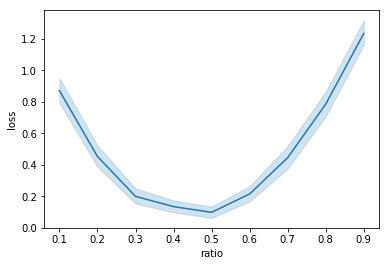

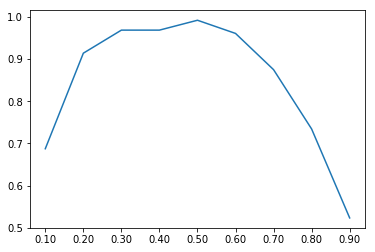

Data Preparation: 51.5s
Epoch: 6 (137.1s)  LR: 0.00078 Train Loss: 0.000058  Valid Loss: 0.456885  Valid Acc: (0.898438, 0.726562)


/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type GNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ModuleList. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type RAGCNConv. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Linear. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won

Data Preparation: 16.5s
Epoch: 7 (132.4s)  LR: 0.00082 Train Loss: 0.000037  Valid Loss: 0.504237  Valid Acc: (0.890625, 0.687500)
Data Preparation: 23.6s
Epoch: 8 (133.8s)  LR: 0.00085 Train Loss: 0.000026  Valid Loss: 0.456609  Valid Acc: (0.867188, 0.781250)


/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type GNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ModuleList. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type RAGCNConv. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Linear. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won

Data Preparation: 20.3s
Epoch: 9 (133.4s)  LR: 0.00088 Train Loss: 0.000027  Valid Loss: 0.436230  Valid Acc: (0.882812, 0.742188)


/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type GNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ModuleList. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type RAGCNConv. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Linear. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won

Data Preparation: 17.7s
Epoch: 10 (133.9s)  LR: 0.00091 Train Loss: 0.000023  Valid Loss: 0.505640  Valid Acc: (0.843750, 0.671875)


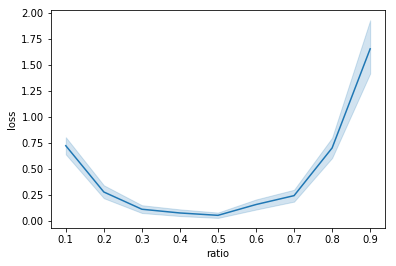

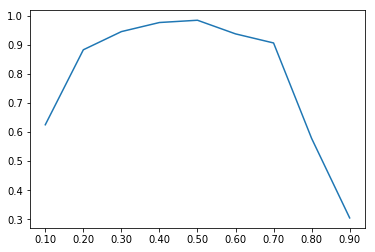

Data Preparation: 51.9s
Epoch: 11 (131.4s)  LR: 0.00094 Train Loss: 0.000015  Valid Loss: 0.433022  Valid Acc: (0.875000, 0.835938)


/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type GNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ModuleList. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type RAGCNConv. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Linear. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won

Data Preparation: 35.5s
Epoch: 12 (134.6s)  LR: 0.00096 Train Loss: 0.000012  Valid Loss: 0.483271  Valid Acc: (0.796875, 0.750000)
Data Preparation: 34.6s
Epoch: 13 (131.6s)  LR: 0.00098 Train Loss: 0.000012  Valid Loss: 0.418836  Valid Acc: (0.882812, 0.773438)


/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type GNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ModuleList. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type RAGCNConv. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Linear. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won

Data Preparation: 36.8s
Epoch: 14 (133.5s)  LR: 0.00099 Train Loss: 0.000210  Valid Loss: 0.304584  Valid Acc: (0.906250, 0.882812)


/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type GNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ModuleList. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type RAGCNConv. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Linear. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won

Data Preparation: 34.8s
Epoch: 15 (140.1s)  LR: 0.00100 Train Loss: 0.000014  Valid Loss: 0.263515  Valid Acc: (0.953125, 0.820312)


/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type GNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ModuleList. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type RAGCNConv. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Linear. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won

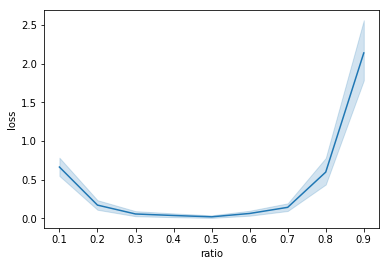

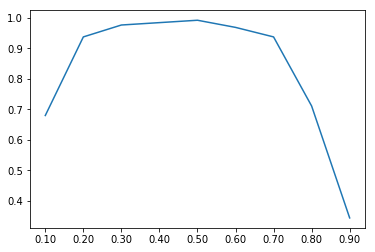

Data Preparation: 52.3s
Epoch: 16 (136.7s)  LR: 0.00100 Train Loss: 0.000009  Valid Loss: 0.268461  Valid Acc: (0.929688, 0.882812)
Data Preparation: 28.5s
Epoch: 17 (134.0s)  LR: 0.00100 Train Loss: 0.000573  Valid Loss: 0.279208  Valid Acc: (0.914062, 0.835938)
Data Preparation: 35.1s
Epoch: 18 (134.6s)  LR: 0.00099 Train Loss: 0.000079  Valid Loss: 0.473643  Valid Acc: (0.867188, 0.726562)
Data Preparation: 38.0s
Epoch: 19 (134.5s)  LR: 0.00098 Train Loss: 0.000134  Valid Loss: 0.466384  Valid Acc: (0.859375, 0.773438)
Data Preparation: 31.0s
Epoch: 20 (132.9s)  LR: 0.00096 Train Loss: 0.000008  Valid Loss: 0.398304  Valid Acc: (0.945312, 0.773438)


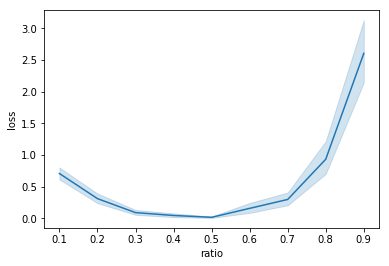

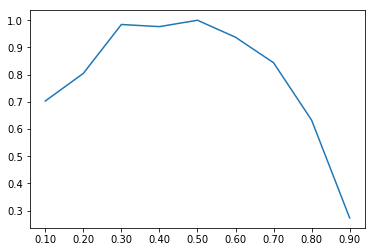

Data Preparation: 66.9s
Epoch: 21 (138.7s)  LR: 0.00094 Train Loss: 0.000005  Valid Loss: 0.430888  Valid Acc: (0.835938, 0.820312)
Data Preparation: 18.9s
Epoch: 22 (129.8s)  LR: 0.00092 Train Loss: 0.000033  Valid Loss: 0.364509  Valid Acc: (0.875000, 0.773438)
Data Preparation: 27.1s
Epoch: 23 (132.9s)  LR: 0.00089 Train Loss: 0.000278  Valid Loss: 0.526377  Valid Acc: (0.835938, 0.710938)
Data Preparation: 27.1s
Epoch: 24 (132.1s)  LR: 0.00086 Train Loss: 0.000628  Valid Loss: 0.638429  Valid Acc: (0.820312, 0.750000)
Data Preparation: 30.5s
Epoch: 25 (140.8s)  LR: 0.00082 Train Loss: 0.000073  Valid Loss: 0.714051  Valid Acc: (0.726562, 0.585938)


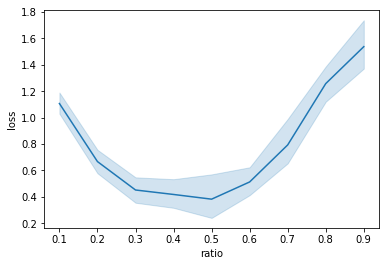

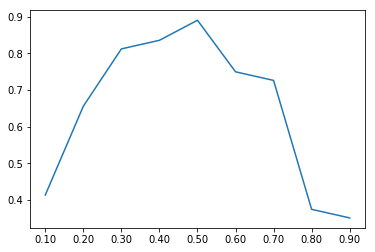

Data Preparation: 54.7s
Epoch: 26 (136.0s)  LR: 0.00079 Train Loss: 0.000005  Valid Loss: 0.745350  Valid Acc: (0.789062, 0.632812)
Data Preparation: 32.1s
Epoch: 27 (131.7s)  LR: 0.00075 Train Loss: 0.000007  Valid Loss: 0.531422  Valid Acc: (0.804688, 0.750000)
Data Preparation: 25.5s
Epoch: 28 (129.5s)  LR: 0.00070 Train Loss: 0.000002  Valid Loss: 0.483899  Valid Acc: (0.843750, 0.734375)
Data Preparation: 34.2s
Epoch: 29 (137.4s)  LR: 0.00066 Train Loss: 0.000004  Valid Loss: 0.722976  Valid Acc: (0.734375, 0.679688)
Data Preparation: 29.7s
Epoch: 30 (135.5s)  LR: 0.00061 Train Loss: 0.000002  Valid Loss: 0.624493  Valid Acc: (0.750000, 0.687500)


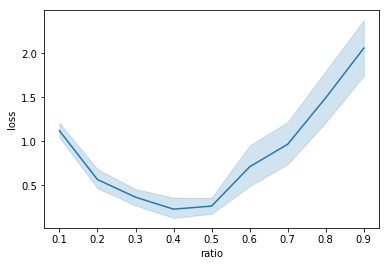

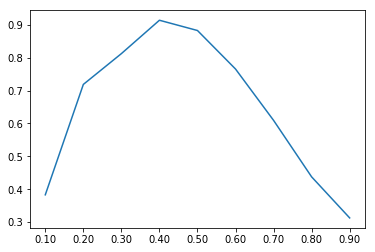

Data Preparation: 65.6s
Epoch: 31 (135.1s)  LR: 0.00056 Train Loss: 0.000088  Valid Loss: 0.717310  Valid Acc: (0.750000, 0.632812)
Data Preparation: 13.4s
Epoch: 32 (127.8s)  LR: 0.00051 Train Loss: 0.000005  Valid Loss: 0.620080  Valid Acc: (0.750000, 0.656250)
Data Preparation: 12.9s
Epoch: 33 (130.7s)  LR: 0.00046 Train Loss: 0.000069  Valid Loss: 1.015663  Valid Acc: (0.648438, 0.640625)
Data Preparation: 21.2s
Epoch: 34 (136.1s)  LR: 0.00042 Train Loss: 0.000010  Valid Loss: 0.692981  Valid Acc: (0.773438, 0.703125)
Data Preparation: 13.5s
Epoch: 35 (134.4s)  LR: 0.00037 Train Loss: 0.000002  Valid Loss: 0.644533  Valid Acc: (0.796875, 0.695312)


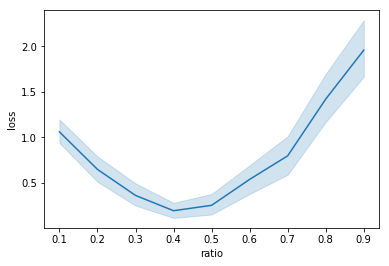

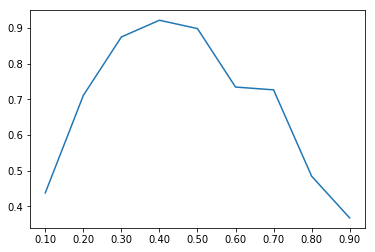

Data Preparation: 53.2s
Epoch: 36 (137.6s)  LR: 0.00032 Train Loss: 0.000002  Valid Loss: 0.636680  Valid Acc: (0.773438, 0.718750)
Data Preparation: 29.6s
Epoch: 37 (135.9s)  LR: 0.00028 Train Loss: 0.000002  Valid Loss: 0.588864  Valid Acc: (0.812500, 0.679688)
Data Preparation: 23.9s
Epoch: 38 (129.8s)  LR: 0.00024 Train Loss: 0.000001  Valid Loss: 0.576370  Valid Acc: (0.765625, 0.796875)
Data Preparation: 31.4s
Epoch: 39 (132.2s)  LR: 0.00020 Train Loss: 0.000001  Valid Loss: 0.471859  Valid Acc: (0.867188, 0.734375)
Data Preparation: 35.9s
Epoch: 40 (137.0s)  LR: 0.00016 Train Loss: 0.000001  Valid Loss: 0.655104  Valid Acc: (0.796875, 0.718750)


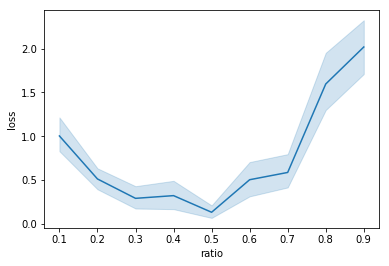

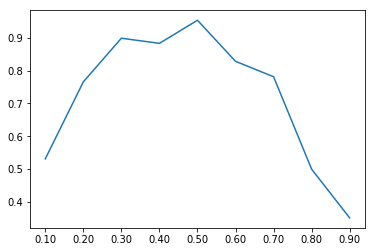

Data Preparation: 67.7s
Epoch: 41 (137.5s)  LR: 0.00012 Train Loss: 0.000001  Valid Loss: 0.727000  Valid Acc: (0.687500, 0.703125)
Data Preparation: 15.5s
Epoch: 42 (136.7s)  LR: 0.00009 Train Loss: 0.000001  Valid Loss: 0.613198  Valid Acc: (0.773438, 0.710938)
Data Preparation: 9.7s
Epoch: 43 (128.1s)  LR: 0.00007 Train Loss: 0.000157  Valid Loss: 0.601286  Valid Acc: (0.820312, 0.679688)
Data Preparation: 28.4s
Epoch: 44 (131.2s)  LR: 0.00005 Train Loss: 0.000001  Valid Loss: 0.574881  Valid Acc: (0.781250, 0.718750)
Data Preparation: 15.7s
Epoch: 45 (130.6s)  LR: 0.00003 Train Loss: 0.000007  Valid Loss: 0.664082  Valid Acc: (0.781250, 0.742188)


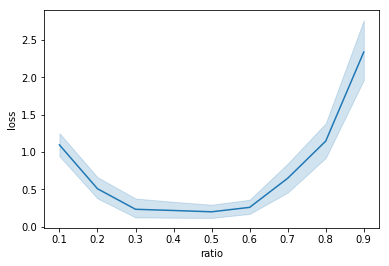

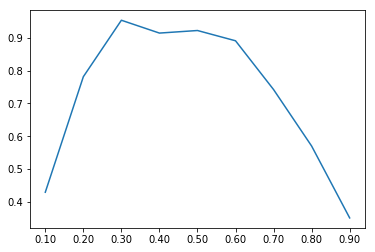

Data Preparation: 55.2s
Epoch: 46 (134.6s)  LR: 0.00001 Train Loss: 0.000010  Valid Loss: 0.629218  Valid Acc: (0.812500, 0.773438)
Data Preparation: 29.7s
Epoch: 47 (140.1s)  LR: 0.00001 Train Loss: 0.000001  Valid Loss: 0.541641  Valid Acc: (0.820312, 0.750000)
Data Preparation: 21.2s
Epoch: 48 (129.8s)  LR: 0.00000 Train Loss: 0.000001  Valid Loss: 0.560501  Valid Acc: (0.851562, 0.710938)
Data Preparation: 31.5s
Epoch: 49 (129.9s)  LR: 0.00000 Train Loss: 0.000002  Valid Loss: 0.647418  Valid Acc: (0.757812, 0.781250)
Data Preparation: 38.1s
Epoch: 50 (135.5s)  LR: 0.00001 Train Loss: 0.000003  Valid Loss: 0.505380  Valid Acc: (0.804688, 0.765625)


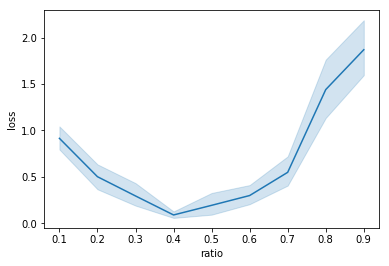

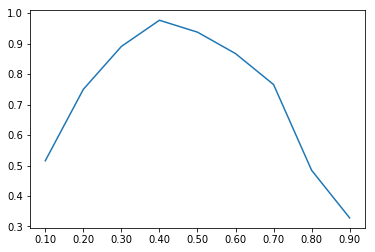

Data Preparation: 65.4s
Epoch: 51 (129.5s)  LR: 0.00002 Train Loss: 0.000009  Valid Loss: 0.692424  Valid Acc: (0.703125, 0.726562)
Data Preparation: 13.9s
Epoch: 52 (128.5s)  LR: 0.00003 Train Loss: 0.000036  Valid Loss: 0.618231  Valid Acc: (0.859375, 0.671875)
Data Preparation: 25.5s
Epoch: 53 (133.3s)  LR: 0.00005 Train Loss: 0.000006  Valid Loss: 0.750684  Valid Acc: (0.750000, 0.695312)
Data Preparation: 21.0s
Epoch: 54 (140.4s)  LR: 0.00007 Train Loss: 0.000004  Valid Loss: 0.591037  Valid Acc: (0.781250, 0.703125)
Data Preparation: 13.7s
Epoch: 55 (137.3s)  LR: 0.00010 Train Loss: 0.000001  Valid Loss: 0.728949  Valid Acc: (0.789062, 0.687500)


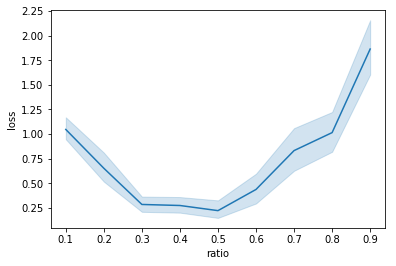

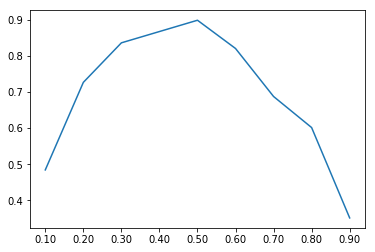

Data Preparation: 56.0s
Epoch: 56 (135.0s)  LR: 0.00013 Train Loss: 0.000005  Valid Loss: 0.539234  Valid Acc: (0.843750, 0.679688)
Data Preparation: 29.6s
Epoch: 57 (132.0s)  LR: 0.00017 Train Loss: 0.000001  Valid Loss: 0.606771  Valid Acc: (0.796875, 0.718750)
Data Preparation: 32.8s
Epoch: 58 (139.4s)  LR: 0.00020 Train Loss: 0.000002  Valid Loss: 0.507565  Valid Acc: (0.867188, 0.742188)
Data Preparation: 28.8s
Epoch: 59 (138.0s)  LR: 0.00024 Train Loss: 0.000001  Valid Loss: 0.595752  Valid Acc: (0.734375, 0.750000)
Data Preparation: 31.4s
Epoch: 60 (134.7s)  LR: 0.00029 Train Loss: 0.000001  Valid Loss: 0.566431  Valid Acc: (0.835938, 0.656250)


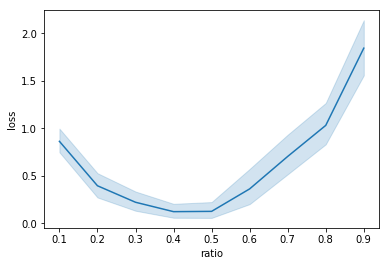

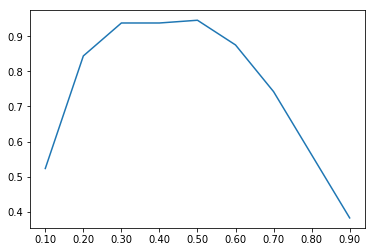

Data Preparation: 55.3s
Epoch: 61 (137.3s)  LR: 0.00033 Train Loss: 0.000001  Valid Loss: 0.479139  Valid Acc: (0.734375, 0.820312)
Data Preparation: 21.9s
Epoch: 62 (130.4s)  LR: 0.00038 Train Loss: 0.000003  Valid Loss: 0.656781  Valid Acc: (0.843750, 0.632812)
Data Preparation: 38.6s
Epoch: 63 (139.0s)  LR: 0.00043 Train Loss: 0.000001  Valid Loss: 0.687992  Valid Acc: (0.750000, 0.710938)
Data Preparation: 20.2s
Epoch: 64 (136.0s)  LR: 0.00048 Train Loss: 0.000001  Valid Loss: 0.615994  Valid Acc: (0.789062, 0.671875)
Data Preparation: 24.4s
Epoch: 65 (139.5s)  LR: 0.00052 Train Loss: 0.000001  Valid Loss: 0.508511  Valid Acc: (0.789062, 0.804688)


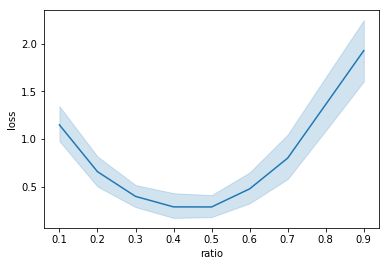

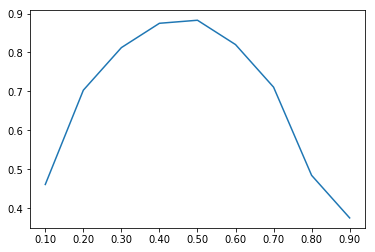

Data Preparation: 66.2s
Epoch: 66 (135.3s)  LR: 0.00057 Train Loss: 0.000214  Valid Loss: 0.643183  Valid Acc: (0.812500, 0.695312)
Data Preparation: 26.5s
Epoch: 67 (136.7s)  LR: 0.00062 Train Loss: 0.000023  Valid Loss: 0.896130  Valid Acc: (0.804688, 0.593750)
Data Preparation: 34.7s
Epoch: 68 (130.4s)  LR: 0.00067 Train Loss: 0.000007  Valid Loss: 0.557177  Valid Acc: (0.765625, 0.773438)
Data Preparation: 36.3s
Epoch: 69 (130.4s)  LR: 0.00071 Train Loss: 0.000002  Valid Loss: 0.445646  Valid Acc: (0.859375, 0.757812)
Data Preparation: 27.5s
Epoch: 70 (131.3s)  LR: 0.00075 Train Loss: 0.000005  Valid Loss: 0.387976  Valid Acc: (0.875000, 0.843750)


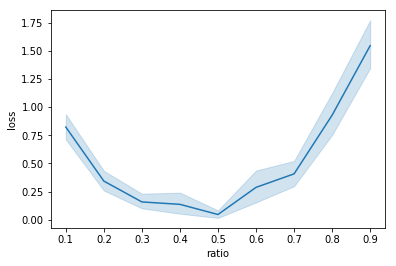

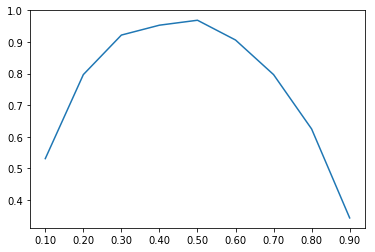

Data Preparation: 55.8s
Epoch: 71 (134.0s)  LR: 0.00080 Train Loss: 0.000001  Valid Loss: 0.535799  Valid Acc: (0.875000, 0.804688)
Data Preparation: 38.0s
Epoch: 72 (135.4s)  LR: 0.00083 Train Loss: 0.000001  Valid Loss: 0.397354  Valid Acc: (0.906250, 0.828125)
Data Preparation: 27.3s
Epoch: 73 (131.3s)  LR: 0.00087 Train Loss: 0.000001  Valid Loss: 0.442475  Valid Acc: (0.882812, 0.781250)
Data Preparation: 36.5s
Epoch: 74 (132.4s)  LR: 0.00090 Train Loss: 0.000001  Valid Loss: 0.345960  Valid Acc: (0.890625, 0.835938)
Data Preparation: 34.8s
Epoch: 75 (135.9s)  LR: 0.00093 Train Loss: 0.000001  Valid Loss: 0.469074  Valid Acc: (0.804688, 0.773438)


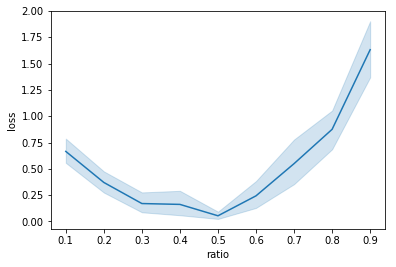

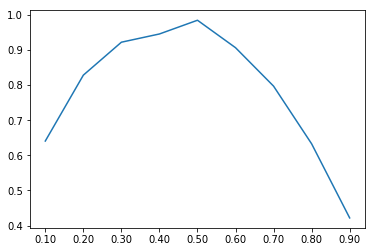

Data Preparation: 65.1s
Epoch: 76 (136.1s)  LR: 0.00095 Train Loss: 0.000001  Valid Loss: 0.361946  Valid Acc: (0.890625, 0.765625)
Data Preparation: 18.1s
Epoch: 77 (128.5s)  LR: 0.00097 Train Loss: 0.000012  Valid Loss: 0.524817  Valid Acc: (0.812500, 0.781250)
Data Preparation: 33.9s
Epoch: 78 (140.0s)  LR: 0.00098 Train Loss: 0.000001  Valid Loss: 0.550604  Valid Acc: (0.812500, 0.773438)
Data Preparation: 3.0s
Epoch: 79 (132.3s)  LR: 0.00099 Train Loss: 0.000001  Valid Loss: 0.430913  Valid Acc: (0.859375, 0.796875)
Data Preparation: 21.9s
Epoch: 80 (132.0s)  LR: 0.00100 Train Loss: 0.000005  Valid Loss: 0.665400  Valid Acc: (0.765625, 0.679688)


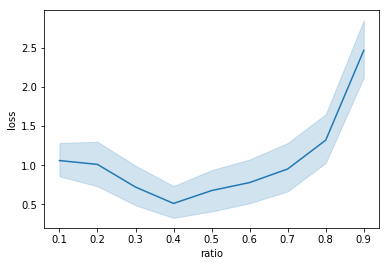

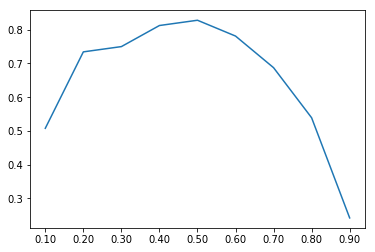

Data Preparation: 56.3s
Epoch: 81 (132.1s)  LR: 0.00100 Train Loss: 0.000002  Valid Loss: 0.448371  Valid Acc: (0.828125, 0.718750)
Data Preparation: 35.2s
Epoch: 82 (139.5s)  LR: 0.00100 Train Loss: 0.000001  Valid Loss: 0.494210  Valid Acc: (0.867188, 0.734375)
Data Preparation: 29.1s
Epoch: 83 (144.1s)  LR: 0.00099 Train Loss: 0.000001  Valid Loss: 0.440845  Valid Acc: (0.859375, 0.765625)
Data Preparation: 20.9s
Epoch: 84 (135.6s)  LR: 0.00097 Train Loss: 0.000001  Valid Loss: 0.338482  Valid Acc: (0.882812, 0.804688)
Data Preparation: 26.5s
Epoch: 85 (138.9s)  LR: 0.00096 Train Loss: 0.000001  Valid Loss: 0.358988  Valid Acc: (0.867188, 0.820312)


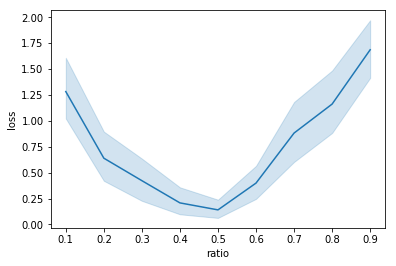

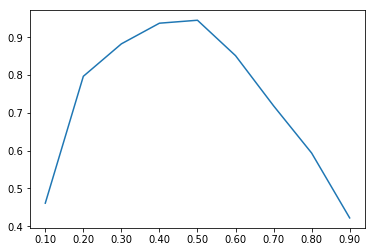

Data Preparation: 63.8s
Epoch: 86 (136.4s)  LR: 0.00093 Train Loss: 0.000000  Valid Loss: 0.420640  Valid Acc: (0.828125, 0.765625)
Data Preparation: 15.9s
Epoch: 87 (132.2s)  LR: 0.00091 Train Loss: 0.000002  Valid Loss: 0.383993  Valid Acc: (0.867188, 0.796875)
Data Preparation: 22.1s
Epoch: 88 (137.3s)  LR: 0.00088 Train Loss: 0.000031  Valid Loss: 0.438718  Valid Acc: (0.890625, 0.734375)
Data Preparation: 15.2s
Epoch: 89 (130.5s)  LR: 0.00084 Train Loss: 0.000416  Valid Loss: 0.510378  Valid Acc: (0.835938, 0.765625)
Data Preparation: 17.4s
Epoch: 90 (126.4s)  LR: 0.00081 Train Loss: 0.001715  Valid Loss: 0.855944  Valid Acc: (0.859375, 0.695312)


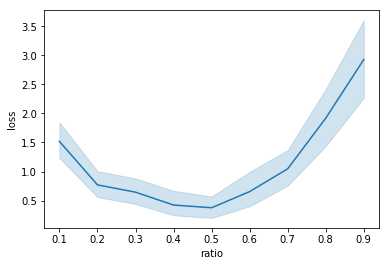

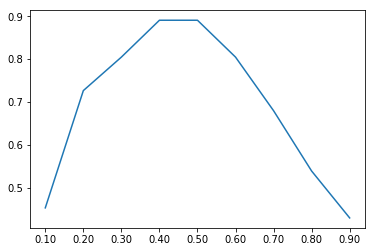

Data Preparation: 55.2s
Epoch: 91 (133.0s)  LR: 0.00077 Train Loss: 0.000024  Valid Loss: 0.727732  Valid Acc: (0.765625, 0.726562)
Data Preparation: 34.8s
Epoch: 92 (134.0s)  LR: 0.00072 Train Loss: 0.000208  Valid Loss: 0.750885  Valid Acc: (0.750000, 0.695312)
Data Preparation: 31.0s
Epoch: 93 (130.8s)  LR: 0.00068 Train Loss: 0.000553  Valid Loss: 0.509806  Valid Acc: (0.773438, 0.757812)
Data Preparation: 34.9s
Epoch: 94 (135.0s)  LR: 0.00063 Train Loss: 0.000490  Valid Loss: 0.588867  Valid Acc: (0.781250, 0.726562)
Data Preparation: 24.5s
Epoch: 95 (134.4s)  LR: 0.00059 Train Loss: 0.000023  Valid Loss: 0.760274  Valid Acc: (0.648438, 0.664062)


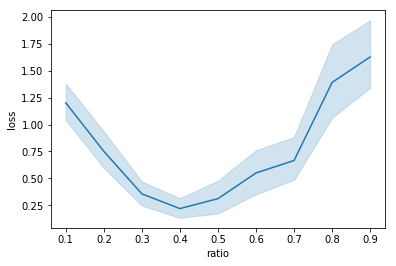

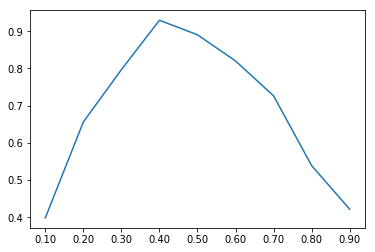

Data Preparation: 65.8s
Epoch: 96 (134.6s)  LR: 0.00054 Train Loss: 0.000001  Valid Loss: 0.494684  Valid Acc: (0.851562, 0.679688)
Data Preparation: 21.1s
Epoch: 97 (135.5s)  LR: 0.00049 Train Loss: 0.000000  Valid Loss: 0.570257  Valid Acc: (0.750000, 0.687500)
Data Preparation: 22.0s
Epoch: 98 (139.1s)  LR: 0.00044 Train Loss: 0.000028  Valid Loss: 0.688329  Valid Acc: (0.703125, 0.710938)
Data Preparation: 13.6s
Epoch: 99 (134.4s)  LR: 0.00039 Train Loss: 0.000004  Valid Loss: 0.664091  Valid Acc: (0.796875, 0.695312)
Data Preparation: 11.8s
Epoch: 100 (134.5s)  LR: 0.00035 Train Loss: 0.000003  Valid Loss: 0.548832  Valid Acc: (0.742188, 0.773438)


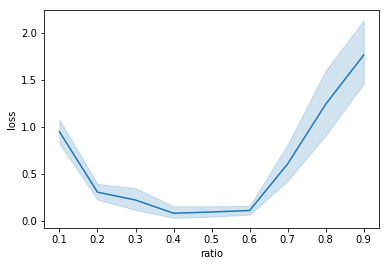

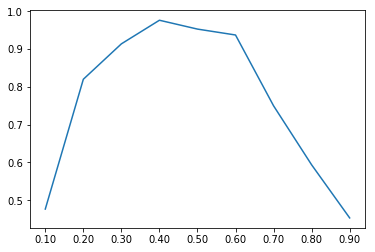

Data Preparation: 52.2s
Epoch: 101 (136.4s)  LR: 0.00030 Train Loss: 0.000001  Valid Loss: 0.647111  Valid Acc: (0.773438, 0.671875)
Data Preparation: 25.5s
Epoch: 102 (134.0s)  LR: 0.00026 Train Loss: 0.000004  Valid Loss: 0.490509  Valid Acc: (0.843750, 0.734375)
Data Preparation: 34.0s
Epoch: 103 (130.1s)  LR: 0.00022 Train Loss: 0.000106  Valid Loss: 0.759688  Valid Acc: (0.773438, 0.625000)
Data Preparation: 35.3s
Epoch: 104 (136.0s)  LR: 0.00018 Train Loss: 0.000004  Valid Loss: 0.723382  Valid Acc: (0.726562, 0.687500)
Data Preparation: 29.3s
Epoch: 105 (133.2s)  LR: 0.00014 Train Loss: 0.000002  Valid Loss: 0.723512  Valid Acc: (0.765625, 0.585938)


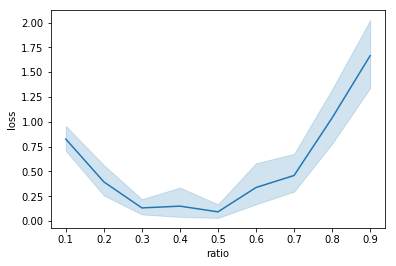

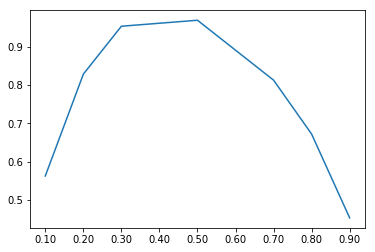

Data Preparation: 53.1s
Epoch: 106 (132.7s)  LR: 0.00011 Train Loss: 0.000005  Valid Loss: 0.644201  Valid Acc: (0.718750, 0.671875)
Data Preparation: 36.5s
Epoch: 107 (136.0s)  LR: 0.00008 Train Loss: 0.000000  Valid Loss: 0.660839  Valid Acc: (0.835938, 0.640625)
Data Preparation: 27.6s
Epoch: 108 (133.4s)  LR: 0.00006 Train Loss: 0.000009  Valid Loss: 0.726256  Valid Acc: (0.773438, 0.664062)
Data Preparation: 34.9s
Epoch: 109 (133.6s)  LR: 0.00004 Train Loss: 0.000000  Valid Loss: 0.678099  Valid Acc: (0.804688, 0.648438)
Data Preparation: 32.0s
Epoch: 110 (129.6s)  LR: 0.00002 Train Loss: 0.000002  Valid Loss: 0.550153  Valid Acc: (0.882812, 0.640625)


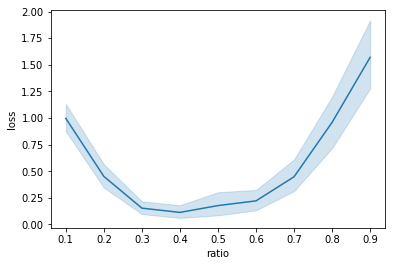

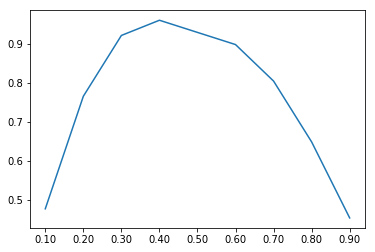

Data Preparation: 66.3s
Epoch: 111 (133.7s)  LR: 0.00001 Train Loss: 0.000004  Valid Loss: 0.562358  Valid Acc: (0.789062, 0.765625)
Data Preparation: 20.3s
Epoch: 112 (134.2s)  LR: 0.00000 Train Loss: 0.000001  Valid Loss: 0.622481  Valid Acc: (0.734375, 0.710938)
Data Preparation: 12.5s
Epoch: 113 (133.7s)  LR: 0.00000 Train Loss: 0.000000  Valid Loss: 0.708909  Valid Acc: (0.796875, 0.671875)
Data Preparation: 14.6s
Epoch: 114 (136.5s)  LR: 0.00000 Train Loss: 0.000002  Valid Loss: 0.595051  Valid Acc: (0.742188, 0.679688)
Data Preparation: 16.4s
Epoch: 115 (128.6s)  LR: 0.00001 Train Loss: 0.000017  Valid Loss: 0.611121  Valid Acc: (0.750000, 0.773438)


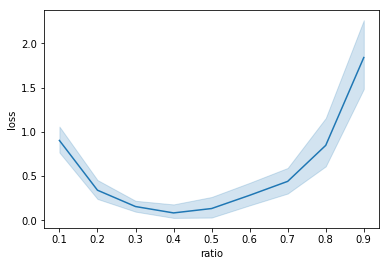

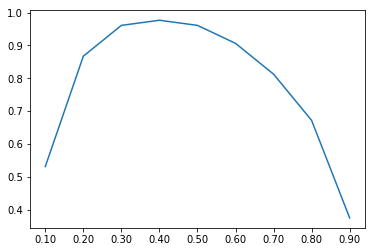

Data Preparation: 51.8s
Epoch: 116 (134.5s)  LR: 0.00002 Train Loss: 0.000001  Valid Loss: 0.720015  Valid Acc: (0.757812, 0.632812)
Data Preparation: 30.6s
Epoch: 117 (137.3s)  LR: 0.00004 Train Loss: 0.000000  Valid Loss: 0.589375  Valid Acc: (0.695312, 0.718750)
Data Preparation: 25.0s
Epoch: 118 (135.0s)  LR: 0.00006 Train Loss: 0.000001  Valid Loss: 0.723338  Valid Acc: (0.742188, 0.687500)
Data Preparation: 34.8s
Epoch: 119 (135.5s)  LR: 0.00009 Train Loss: 0.000001  Valid Loss: 0.665841  Valid Acc: (0.804688, 0.679688)
Data Preparation: 30.8s
Epoch: 120 (133.9s)  LR: 0.00012 Train Loss: 0.000000  Valid Loss: 0.714488  Valid Acc: (0.726562, 0.726562)


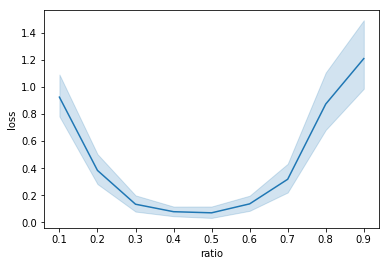

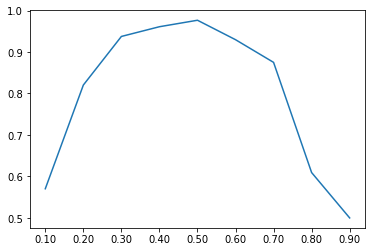

Data Preparation: 66.4s
Epoch: 121 (129.4s)  LR: 0.00015 Train Loss: 0.000001  Valid Loss: 0.624327  Valid Acc: (0.765625, 0.687500)
Data Preparation: 27.0s
Epoch: 122 (132.7s)  LR: 0.00018 Train Loss: 0.000000  Valid Loss: 0.607467  Valid Acc: (0.828125, 0.656250)
Data Preparation: 19.8s
Epoch: 123 (137.2s)  LR: 0.00022 Train Loss: 0.000000  Valid Loss: 0.636626  Valid Acc: (0.734375, 0.718750)
Data Preparation: 9.8s
Epoch: 124 (136.2s)  LR: 0.00027 Train Loss: 0.000001  Valid Loss: 0.785739  Valid Acc: (0.757812, 0.671875)
Data Preparation: 17.1s
Epoch: 125 (132.6s)  LR: 0.00031 Train Loss: 0.000000  Valid Loss: 0.621612  Valid Acc: (0.726562, 0.710938)


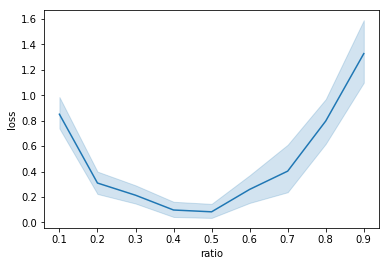

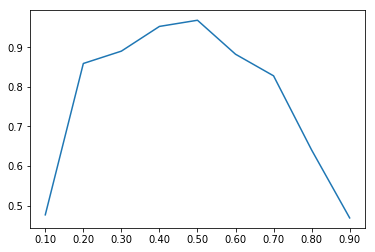

Data Preparation: 52.3s
Epoch: 126 (130.0s)  LR: 0.00036 Train Loss: 0.000000  Valid Loss: 0.737253  Valid Acc: (0.781250, 0.687500)
Data Preparation: 30.2s
Epoch: 127 (132.7s)  LR: 0.00040 Train Loss: 0.000000  Valid Loss: 0.487187  Valid Acc: (0.812500, 0.718750)
Data Preparation: 28.5s
Epoch: 128 (137.9s)  LR: 0.00045 Train Loss: 0.000000  Valid Loss: 0.596979  Valid Acc: (0.773438, 0.765625)
Data Preparation: 27.8s
Epoch: 129 (131.4s)  LR: 0.00050 Train Loss: 0.000000  Valid Loss: 0.742720  Valid Acc: (0.718750, 0.703125)
Data Preparation: 33.8s
Epoch: 130 (132.4s)  LR: 0.00055 Train Loss: 0.000044  Valid Loss: 0.544728  Valid Acc: (0.820312, 0.679688)


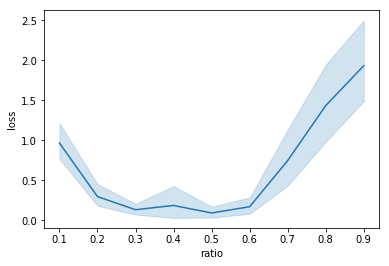

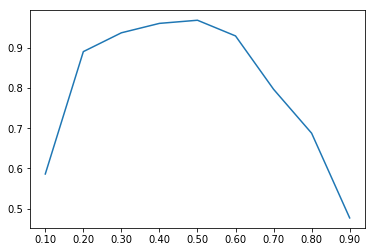

Data Preparation: 68.9s
Epoch: 131 (133.7s)  LR: 0.00060 Train Loss: 0.000003  Valid Loss: 0.494600  Valid Acc: (0.843750, 0.757812)
Data Preparation: 16.4s
Epoch: 132 (135.2s)  LR: 0.00064 Train Loss: 0.000001  Valid Loss: 0.633809  Valid Acc: (0.781250, 0.695312)
Data Preparation: 10.1s
Epoch: 133 (133.2s)  LR: 0.00069 Train Loss: 0.000000  Valid Loss: 0.606985  Valid Acc: (0.867188, 0.687500)
Data Preparation: 20.2s
Epoch: 134 (141.4s)  LR: 0.00073 Train Loss: 0.000000  Valid Loss: 0.794152  Valid Acc: (0.867188, 0.632812)
Data Preparation: 10.2s
Epoch: 135 (136.1s)  LR: 0.00077 Train Loss: 0.000000  Valid Loss: 0.599220  Valid Acc: (0.789062, 0.656250)


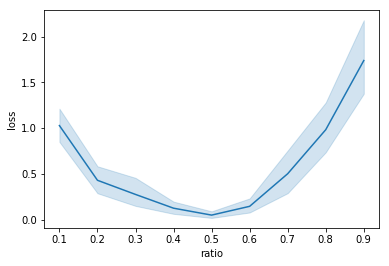

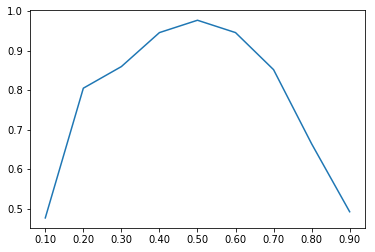

Data Preparation: 53.8s
Epoch: 136 (131.9s)  LR: 0.00081 Train Loss: 0.000000  Valid Loss: 0.509646  Valid Acc: (0.851562, 0.750000)
Data Preparation: 34.2s
Epoch: 137 (131.5s)  LR: 0.00085 Train Loss: 0.000000  Valid Loss: 0.537748  Valid Acc: (0.835938, 0.679688)
Data Preparation: 33.7s
Epoch: 138 (137.5s)  LR: 0.00088 Train Loss: 0.000000  Valid Loss: 0.555175  Valid Acc: (0.820312, 0.671875)
Data Preparation: 26.3s
Epoch: 139 (132.2s)  LR: 0.00091 Train Loss: 0.000000  Valid Loss: 0.674971  Valid Acc: (0.828125, 0.687500)
Data Preparation: 44.4s
Epoch: 140 (135.0s)  LR: 0.00094 Train Loss: 0.000001  Valid Loss: 0.451263  Valid Acc: (0.820312, 0.726562)


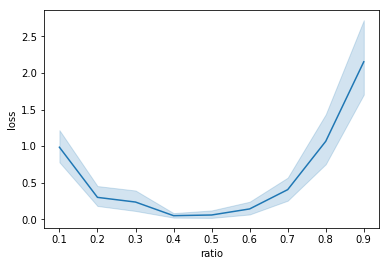

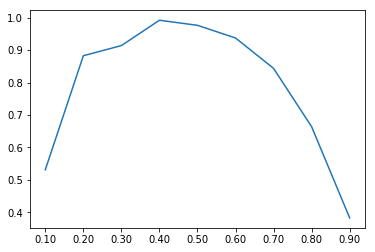

Data Preparation: 54.2s
Epoch: 141 (134.5s)  LR: 0.00096 Train Loss: 0.000000  Valid Loss: 0.669154  Valid Acc: (0.851562, 0.742188)
Data Preparation: 28.8s
Epoch: 142 (132.2s)  LR: 0.00098 Train Loss: 0.000000  Valid Loss: 0.634926  Valid Acc: (0.757812, 0.718750)
Data Preparation: 31.1s
Epoch: 143 (137.8s)  LR: 0.00099 Train Loss: 0.000000  Valid Loss: 0.453943  Valid Acc: (0.882812, 0.765625)
Data Preparation: 28.4s
Epoch: 144 (130.1s)  LR: 0.00100 Train Loss: 0.000000  Valid Loss: 0.505512  Valid Acc: (0.812500, 0.789062)
Data Preparation: 35.8s
Epoch: 145 (136.1s)  LR: 0.00100 Train Loss: 0.000000  Valid Loss: 0.570021  Valid Acc: (0.796875, 0.750000)


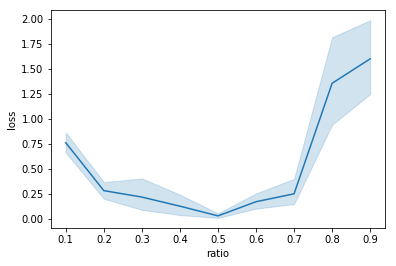

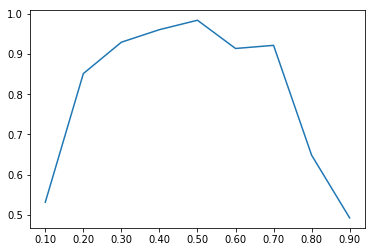

Data Preparation: 65.6s
Epoch: 146 (137.0s)  LR: 0.00100 Train Loss: 0.000000  Valid Loss: 0.471092  Valid Acc: (0.750000, 0.789062)
Data Preparation: 14.4s
Epoch: 147 (132.5s)  LR: 0.00099 Train Loss: 0.000000  Valid Loss: 0.548544  Valid Acc: (0.867188, 0.773438)
Data Preparation: 20.7s
Epoch: 148 (135.9s)  LR: 0.00098 Train Loss: 0.000000  Valid Loss: 0.880740  Valid Acc: (0.812500, 0.578125)
Data Preparation: 21.8s
Epoch: 149 (131.2s)  LR: 0.00097 Train Loss: 0.000000  Valid Loss: 0.502728  Valid Acc: (0.843750, 0.710938)
Data Preparation: 22.6s
Epoch: 150 (138.5s)  LR: 0.00095 Train Loss: 0.000001  Valid Loss: 0.734913  Valid Acc: (0.812500, 0.601562)


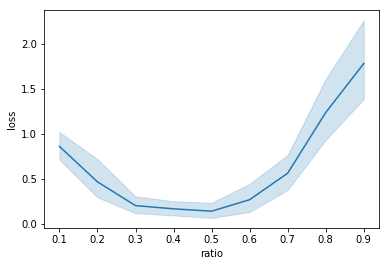

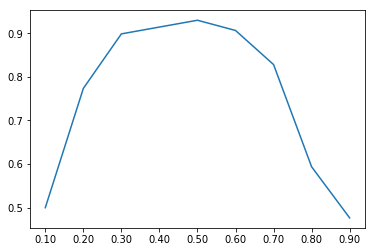

Data Preparation: 54.9s
Epoch: 151 (132.6s)  LR: 0.00092 Train Loss: 0.000000  Valid Loss: 0.714703  Valid Acc: (0.773438, 0.632812)
Data Preparation: 37.2s
Epoch: 152 (138.0s)  LR: 0.00089 Train Loss: 0.000001  Valid Loss: 0.841290  Valid Acc: (0.578125, 0.648438)
Data Preparation: 30.8s
Epoch: 153 (137.9s)  LR: 0.00086 Train Loss: 0.000000  Valid Loss: 0.720937  Valid Acc: (0.804688, 0.687500)
Data Preparation: 27.9s
Epoch: 154 (138.7s)  LR: 0.00083 Train Loss: 0.000000  Valid Loss: 0.639627  Valid Acc: (0.742188, 0.695312)
Data Preparation: 21.2s
Epoch: 155 (133.4s)  LR: 0.00079 Train Loss: 0.000000  Valid Loss: 0.666889  Valid Acc: (0.734375, 0.734375)


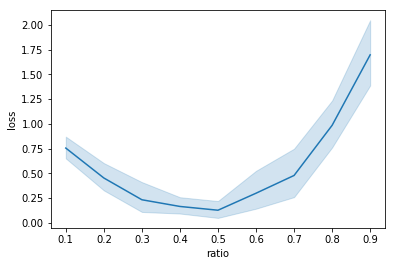

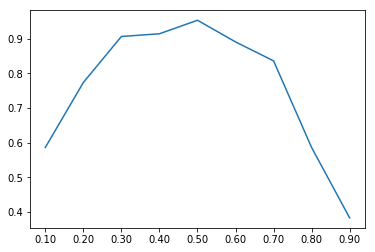

Data Preparation: 64.5s
Epoch: 156 (134.5s)  LR: 0.00075 Train Loss: 0.000002  Valid Loss: 0.758184  Valid Acc: (0.742188, 0.617188)
Data Preparation: 13.5s
Epoch: 157 (128.8s)  LR: 0.00070 Train Loss: 0.000000  Valid Loss: 0.713979  Valid Acc: (0.828125, 0.593750)
Data Preparation: 26.0s
Epoch: 158 (137.3s)  LR: 0.00066 Train Loss: 0.000000  Valid Loss: 0.679895  Valid Acc: (0.765625, 0.656250)
Data Preparation: 18.4s
Epoch: 159 (137.1s)  LR: 0.00061 Train Loss: 0.000000  Valid Loss: 0.681702  Valid Acc: (0.742188, 0.679688)
Data Preparation: 14.1s
Epoch: 160 (137.3s)  LR: 0.00056 Train Loss: 0.000000  Valid Loss: 0.886403  Valid Acc: (0.773438, 0.656250)


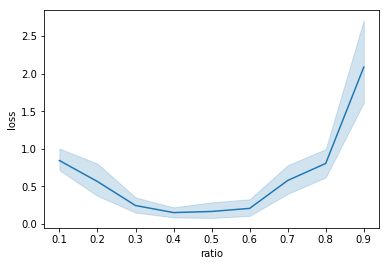

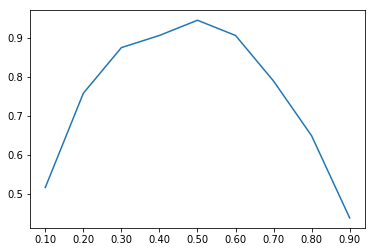

Data Preparation: 54.4s
Epoch: 161 (131.5s)  LR: 0.00051 Train Loss: 0.000000  Valid Loss: 0.600379  Valid Acc: (0.718750, 0.679688)
Data Preparation: 32.0s
Epoch: 162 (138.2s)  LR: 0.00047 Train Loss: 0.000000  Valid Loss: 0.829223  Valid Acc: (0.710938, 0.703125)
Data Preparation: 28.3s
Epoch: 163 (132.1s)  LR: 0.00042 Train Loss: 0.000000  Valid Loss: 0.726108  Valid Acc: (0.710938, 0.632812)
Data Preparation: 36.8s
Epoch: 164 (132.4s)  LR: 0.00037 Train Loss: 0.000001  Valid Loss: 1.015573  Valid Acc: (0.703125, 0.695312)
Data Preparation: 36.2s
Epoch: 165 (133.3s)  LR: 0.00032 Train Loss: 0.000000  Valid Loss: 0.548415  Valid Acc: (0.773438, 0.781250)


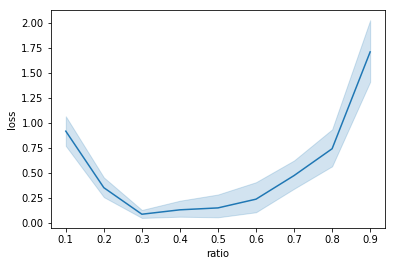

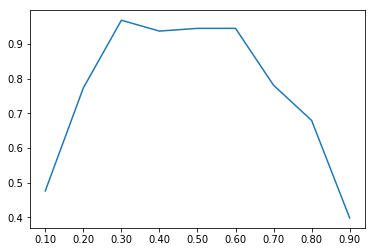

Data Preparation: 66.4s
Epoch: 166 (138.8s)  LR: 0.00028 Train Loss: 0.000382  Valid Loss: 0.633805  Valid Acc: (0.750000, 0.609375)
Data Preparation: 8.4s
Epoch: 167 (131.6s)  LR: 0.00024 Train Loss: 0.000000  Valid Loss: 0.607976  Valid Acc: (0.765625, 0.679688)
Data Preparation: 13.5s
Epoch: 168 (135.2s)  LR: 0.00020 Train Loss: 0.000009  Valid Loss: 0.618331  Valid Acc: (0.796875, 0.671875)
Data Preparation: 21.4s
Epoch: 169 (138.0s)  LR: 0.00016 Train Loss: 0.000000  Valid Loss: 0.553225  Valid Acc: (0.820312, 0.679688)
Data Preparation: 17.7s
Epoch: 170 (136.6s)  LR: 0.00013 Train Loss: 0.000000  Valid Loss: 0.545477  Valid Acc: (0.781250, 0.695312)


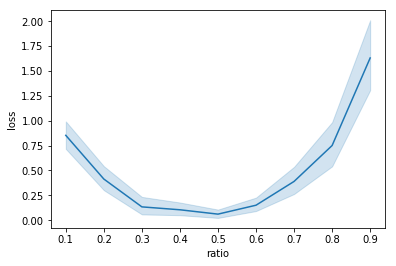

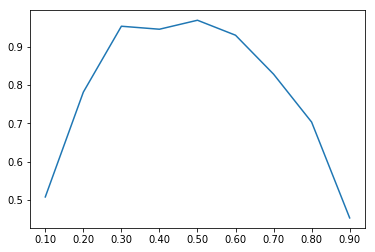

Data Preparation: 54.3s
Epoch: 171 (135.2s)  LR: 0.00010 Train Loss: 0.000000  Valid Loss: 0.646507  Valid Acc: (0.750000, 0.687500)
Data Preparation: 35.4s
Epoch: 172 (136.4s)  LR: 0.00007 Train Loss: 0.000000  Valid Loss: 0.677249  Valid Acc: (0.781250, 0.710938)
Data Preparation: 27.3s
Epoch: 173 (131.0s)  LR: 0.00005 Train Loss: 0.000000  Valid Loss: 0.645519  Valid Acc: (0.796875, 0.671875)
Data Preparation: 34.9s
Epoch: 174 (134.8s)  LR: 0.00003 Train Loss: 0.000000  Valid Loss: 0.529652  Valid Acc: (0.828125, 0.710938)
Data Preparation: 27.8s
Epoch: 175 (130.6s)  LR: 0.00001 Train Loss: 0.000000  Valid Loss: 0.622508  Valid Acc: (0.812500, 0.703125)


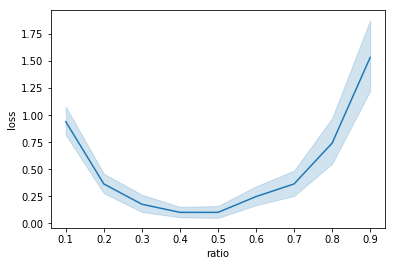

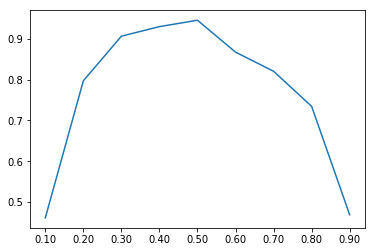

Data Preparation: 55.4s
Epoch: 176 (133.8s)  LR: 0.00001 Train Loss: 0.000000  Valid Loss: 0.611157  Valid Acc: (0.789062, 0.710938)
Data Preparation: 33.7s
Epoch: 177 (136.4s)  LR: 0.00000 Train Loss: 0.000000  Valid Loss: 0.689859  Valid Acc: (0.804688, 0.648438)
Data Preparation: 34.4s
Epoch: 178 (132.0s)  LR: 0.00000 Train Loss: 0.000000  Valid Loss: 0.621654  Valid Acc: (0.757812, 0.695312)
Data Preparation: 34.9s
Epoch: 179 (127.3s)  LR: 0.00001 Train Loss: 0.000034  Valid Loss: 0.781844  Valid Acc: (0.671875, 0.718750)
Data Preparation: 40.9s
Epoch: 180 (137.5s)  LR: 0.00002 Train Loss: 0.000000  Valid Loss: 0.663219  Valid Acc: (0.781250, 0.687500)


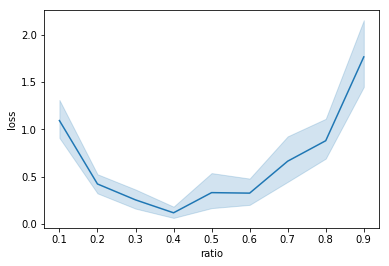

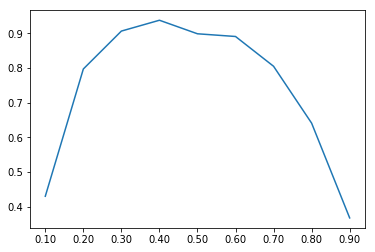

Data Preparation: 66.7s
Epoch: 181 (134.4s)  LR: 0.00003 Train Loss: 0.000000  Valid Loss: 0.635074  Valid Acc: (0.781250, 0.710938)
Data Preparation: 10.7s
Epoch: 182 (132.1s)  LR: 0.00005 Train Loss: 0.000033  Valid Loss: 0.526619  Valid Acc: (0.773438, 0.710938)
Data Preparation: 23.8s
Epoch: 183 (135.4s)  LR: 0.00007 Train Loss: 0.000000  Valid Loss: 0.576235  Valid Acc: (0.828125, 0.695312)
Data Preparation: 21.9s
Epoch: 184 (138.4s)  LR: 0.00010 Train Loss: 0.000000  Valid Loss: 0.748211  Valid Acc: (0.726562, 0.734375)
Data Preparation: 10.9s
Epoch: 185 (137.7s)  LR: 0.00013 Train Loss: 0.000000  Valid Loss: 0.636491  Valid Acc: (0.796875, 0.726562)


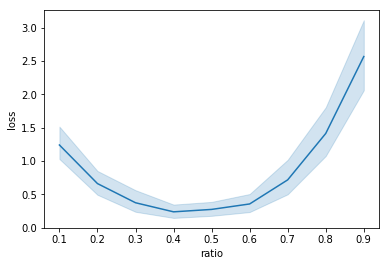

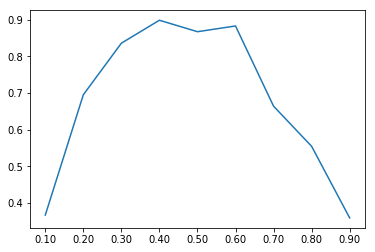

Data Preparation: 54.1s
Epoch: 186 (136.0s)  LR: 0.00017 Train Loss: 0.000000  Valid Loss: 0.663033  Valid Acc: (0.796875, 0.625000)
Data Preparation: 22.4s
Epoch: 187 (132.7s)  LR: 0.00020 Train Loss: 0.000000  Valid Loss: 0.562838  Valid Acc: (0.796875, 0.703125)
Data Preparation: 30.0s
Epoch: 188 (138.8s)  LR: 0.00024 Train Loss: 0.000000  Valid Loss: 0.539904  Valid Acc: (0.820312, 0.703125)
Data Preparation: 25.2s
Epoch: 189 (137.2s)  LR: 0.00029 Train Loss: 0.000000  Valid Loss: 0.612710  Valid Acc: (0.789062, 0.695312)
Data Preparation: 28.4s
Epoch: 190 (131.7s)  LR: 0.00033 Train Loss: 0.000000  Valid Loss: 0.579225  Valid Acc: (0.781250, 0.710938)


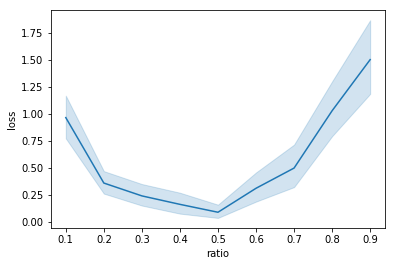

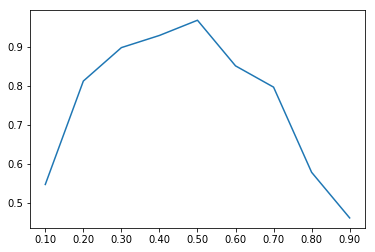

Data Preparation: 68.9s
Epoch: 191 (133.5s)  LR: 0.00038 Train Loss: 0.000000  Valid Loss: 0.530937  Valid Acc: (0.781250, 0.695312)
Data Preparation: 17.8s
Epoch: 192 (139.6s)  LR: 0.00043 Train Loss: 0.000000  Valid Loss: 0.556619  Valid Acc: (0.835938, 0.695312)
Data Preparation: 9.9s
Epoch: 193 (131.8s)  LR: 0.00047 Train Loss: 0.000000  Valid Loss: 0.593329  Valid Acc: (0.804688, 0.703125)
Data Preparation: 15.8s
Epoch: 194 (131.3s)  LR: 0.00052 Train Loss: 0.000000  Valid Loss: 0.589872  Valid Acc: (0.757812, 0.718750)
Data Preparation: 20.0s
Epoch: 195 (131.0s)  LR: 0.00057 Train Loss: 0.000000  Valid Loss: 0.654618  Valid Acc: (0.718750, 0.687500)


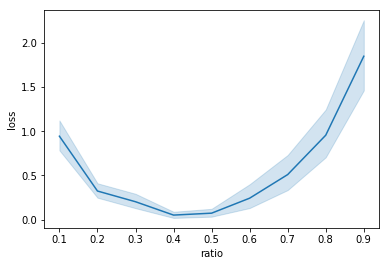

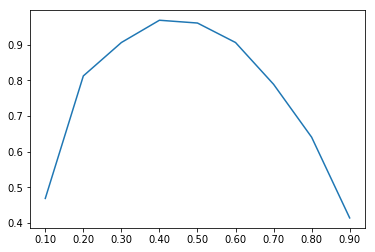

Data Preparation: 55.4s
Epoch: 196 (139.6s)  LR: 0.00062 Train Loss: 0.000000  Valid Loss: 0.591067  Valid Acc: (0.820312, 0.718750)
Data Preparation: 18.1s
Epoch: 197 (127.2s)  LR: 0.00067 Train Loss: 0.000000  Valid Loss: 0.655068  Valid Acc: (0.726562, 0.664062)
Data Preparation: 33.4s
Epoch: 198 (131.7s)  LR: 0.00071 Train Loss: 0.000003  Valid Loss: 0.516333  Valid Acc: (0.789062, 0.703125)
Data Preparation: 32.8s
Epoch: 199 (129.4s)  LR: 0.00075 Train Loss: 0.000608  Valid Loss: 0.939514  Valid Acc: (0.695312, 0.593750)
Data Preparation: 39.2s
Epoch: 200 (133.4s)  LR: 0.00079 Train Loss: 0.000126  Valid Loss: 0.718974  Valid Acc: (0.718750, 0.625000)


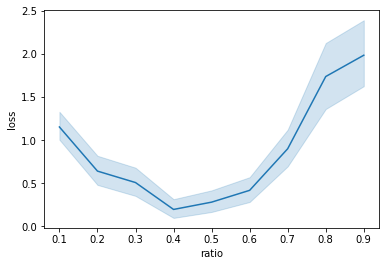

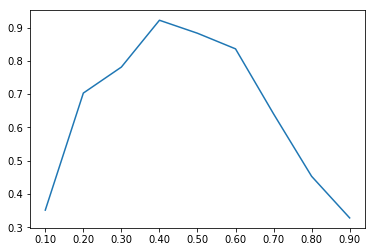

In [8]:
stats = []
pool = mp.Pool(4)
process_ids = np.arange(batch_num // 4)
st = time.time()
jobs = prepare_data(pool, process_ids)
train_step = 1500
best_val   = 100000
for epoch in np.arange(epoch_num)+1:
    train_data = [job.get() for job in jobs[:-2]]
    valid_data = [jobs[-2].get(), jobs[-1].get()]
    pool.close()
    pool.join()
    pool = mp.Pool(4)
    jobs = prepare_data(pool, process_ids)
    et = time.time()
    print('Data Preparation: %.1fs' % (et - st))
    
    train_losses = []
    cpc_predictor.train()
    torch.cuda.empty_cache()
    for data, paper_ids, num_fake in train_data:
        loss, pred = cpc_loss(data, paper_ids, num_fake, cpc_predictor, device)
        optimizer.zero_grad() 
        loss.mean().backward()
        torch.nn.utils.clip_grad_norm_(cpc_predictor.parameters(), 0.2)
        optimizer.step()
        train_losses += loss.cpu().detach().tolist()
        train_step += 1
        scheduler.step(train_step)
        del loss, pred
        torch.cuda.empty_cache()
    '''
        Valid
    '''
    cpc_predictor.eval()
    with torch.no_grad():
        valid_accs   = []
        valid_losses = []
        for data, paper_ids, num_fake in valid_data:
            loss, pred = cpc_loss(data, paper_ids, num_fake, cpc_predictor, device)
            valid_losses += loss.cpu().detach().tolist()
            s = (pred.argmax(dim=1) == 0).sum()
            valid_accs += [s.tolist()/batch_size]
        st = time.time()
        print(("Epoch: %d (%.1fs)  LR: %.5f Train Loss: %f  Valid Loss: %f  Valid Acc: (%f, %f)") % \
              (epoch, (st-et), optimizer.param_groups[0]['lr'], np.average(train_losses), \
               np.average(valid_losses), valid_accs[0], valid_accs[1]))
        if np.average(valid_losses) < best_val:
            best_val = np.average(valid_losses)
            torch.save(cpc_predictor.gnn, './save/cpc_model.pt')
        stats += [[train_losses, valid_losses]]
        
        if epoch % 5 == 0:
            feature, _time, edge_list, _ = sample_subgraph(graph, test_range, inp = None, sampled_depth = 4, sampled_number = 128)
            losses = []
            accs   = []
            for ratio in np.arange(9) / 10 + 0.1:
                fake_feature, fake_time, fake_edge_list, paper_ids = cpc_sample(np.random.randint(2**32 - 1), \
                                                                feature, _time, edge_list, batch_size, 5, ratio)
                data = to_torch(fake_feature, fake_time, fake_edge_list, graph)
                loss, pred = cpc_loss(data, paper_ids, len(fake_time['fake_paper']), cpc_predictor, device)
                for li in loss.tolist():
                    losses += [[li, ratio]]
                s = (pred.argmax(dim=1) == 0).sum()
                acc = s.tolist() / batch_size
                accs += [acc]
                del loss, pred
                torch.cuda.empty_cache()
            sb.lineplot(data = pd.DataFrame(losses, columns=['loss', 'ratio']), x = 'ratio', y='loss')
            plt.show()
            plt.plot(accs)
            plt.xticks(np.arange(9), ['%.2f' % si for si in np.arange(9) / 10 + 0.1])
            plt.show()

In [14]:
losses = []
for epoch, (train_losses, valid_losses) in enumerate(stats):
#     for ti in train_losses:
#         losses += [[ti, 'Train', epoch]]
    for ti in valid_losses:
        losses += [[ti, 'Valid', epoch]]

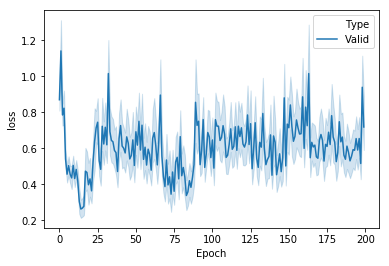

In [15]:
sb.lineplot(data = pd.DataFrame(losses, columns=['loss', 'Type', 'Epoch']), x = 'Epoch', y='loss', hue='Type')
plt.show()